# Task: Timeseries Forecasting for Weather Prediction, using LSTM

In [7]:
# Check if the GPU is available
!nvidia-smi

Sun Mar 16 10:32:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
# Import functions
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
from zipfile import ZipFile
import os

# Initialize Keras
tf.keras.backend.clear_session()
tf.random.set_seed(123)
np.random.seed(123)

In [9]:
# Import the dataset
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"
df = pd.read_csv(csv_path)

df.info()
# We need to provide titles by ourselves here

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [10]:
# Manually providing column names
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
    ]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
    ]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
    ]

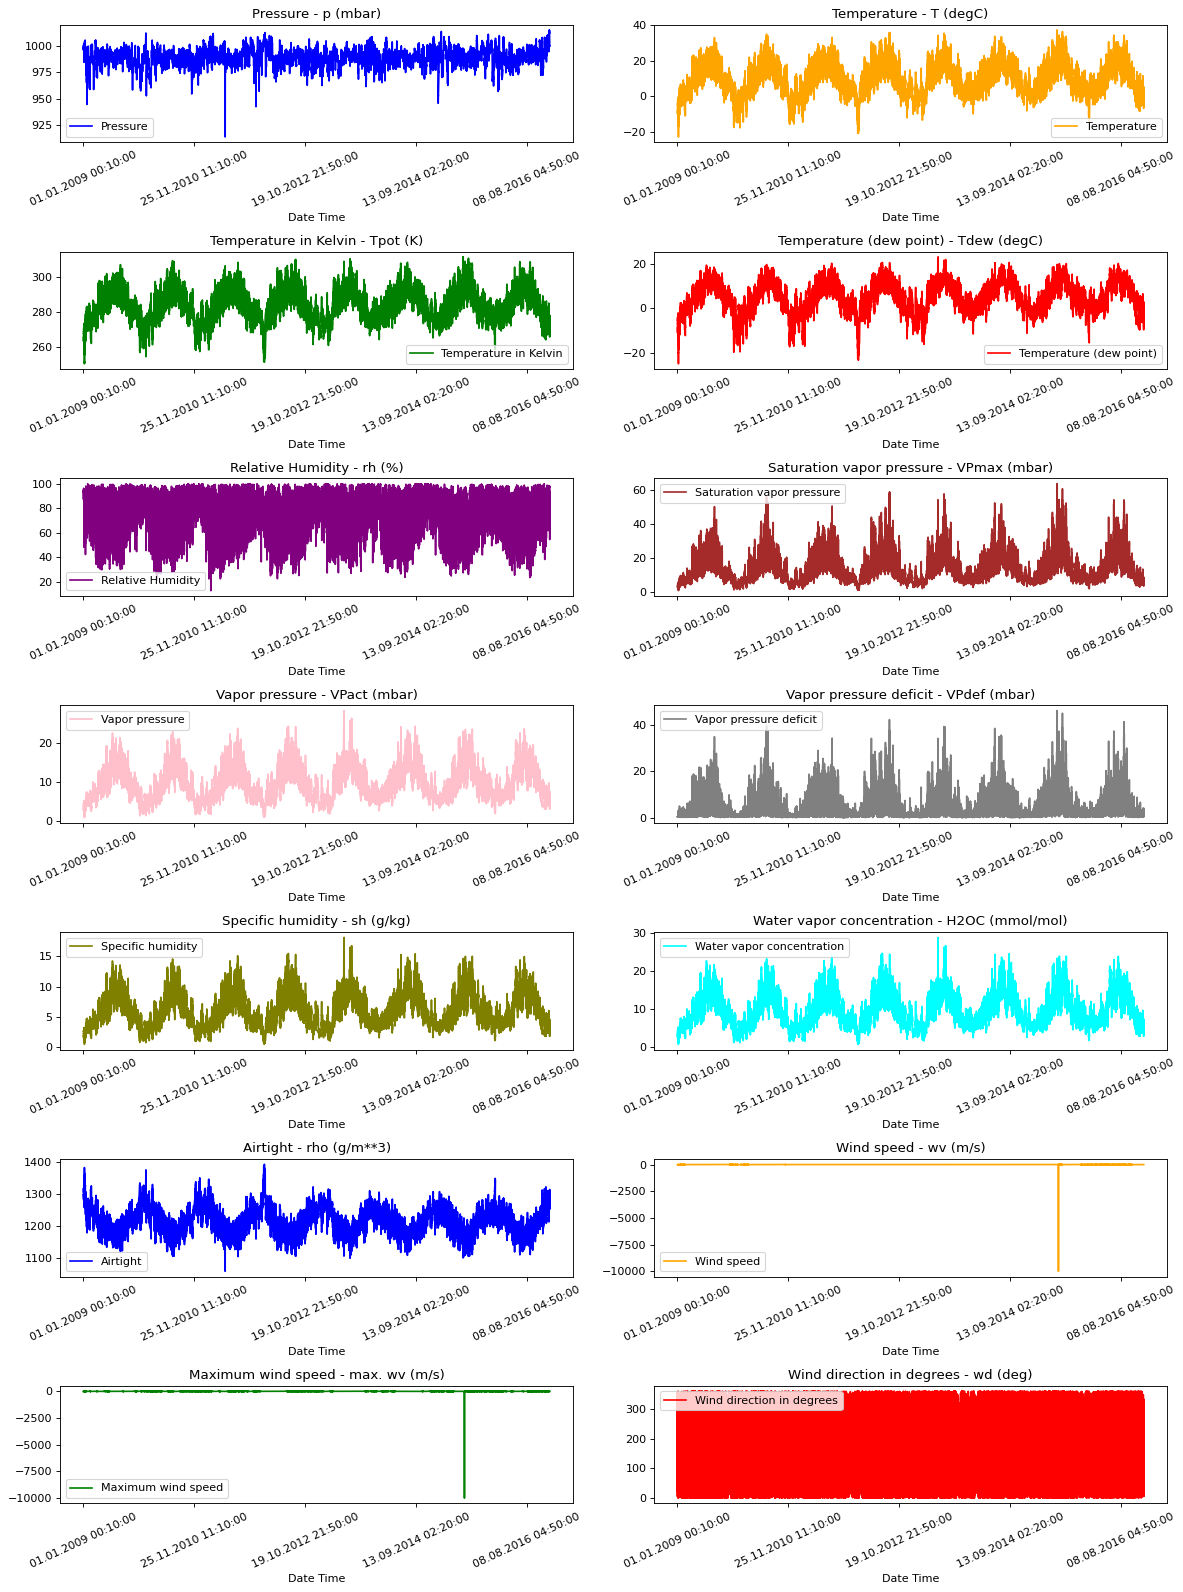

In [11]:
# Visualize the whole dataset
date_time_key = "Date Time"

def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
    nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
        ax=axes[i // 2, i % 2],
        color=c,
        title="{} - {}".format(titles[i], key),
        rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()

show_raw_visualization(df)

In [12]:

split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6
past = 720
future = 72
batch_size = 256
learning_rate = 0.001
epochs = 10

def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()

print(f'The selected parameters are:,{", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]])}')

# We only select specific features
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]

features = df[selected_features]
features.index = df[date_time_key]
features.head()
features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()
train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

The selected parameters are:,Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


In [13]:
start = past + future
end = start + train_split
x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]
sequence_length = int(past / step)
dataset_train = keras.preprocessing.timeseries_dataset_from_array(x_train,
                                                                  y_train,sequence_length=sequence_length,
                                                                  sampling_rate=step,
                                                                  batch_size=batch_size)
x_end = len(val_data) - past - future
label_start = train_split + past + future
x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]
dataset_val = keras.preprocessing.timeseries_dataset_from_array(x_val,
                                                                y_val,
                                                                sequence_length=sequence_length,
                                                                sampling_rate=step,
                                                                batch_size=batch_size)

for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 7)
Target shape: (256, 1)


In [19]:
# Define the input and output
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
cnn_out = keras.layers.Dense(16)(lstm_out)
outputs = keras.layers.Dense(1)(cnn_out)

# 1. Initialize the model
model = keras.Model(inputs=inputs, outputs=outputs)
# 2. Provide compilation configuration
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
# Visualize info
model.summary() # Provides an tabular info of the model.

path_checkpoint = "model_checkpoint.weights.h5" # Store the checkpoint (intermediate epoch parameters) in a file
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)
modelckpt_callback = keras.callbacks.ModelCheckpoint(monitor="val_loss",
                                                    filepath=path_checkpoint,
                                                    verbose=1,
                                                    save_weights_only=True,
                                                    save_best_only=True,
                                                    )
# 3. Train (Fit) the model
history = model.fit(dataset_train,epochs=epochs,validation_data=dataset_val,callbacks=[es_callback, modelckpt_callback])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 120, 7)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,665 (22.13 KB)

 Trainable params: 5,665 (22.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1171/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.4295
Epoch 1: val_loss improved from inf to 0.18483, saving model to model_checkpoint.weights.h5
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - loss: 0.4292 - val_loss: 0.1848
Epoch 2/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1534
Epoch 2: val_loss improved from 0.18483 to 0.15562, saving model to model_checkpoint.weights.h5
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 58s 50ms/step - loss: 0.1534 - val_loss: 0.1556
Epoch 3/10
1171/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1314
Epoch 3: val_loss did not improve from 0.15562
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 57s 49ms/step - loss: 0.1314 - val_loss: 0.1607
Epoch 4/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1252
Epoch 4: val_loss did not improve from 0.15562
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 49s 42ms/step - loss: 0.1252 - val_loss: 0.1667
Epoch 5/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1212
Epoch 5: val_loss did not improve from 0.15562
1172/

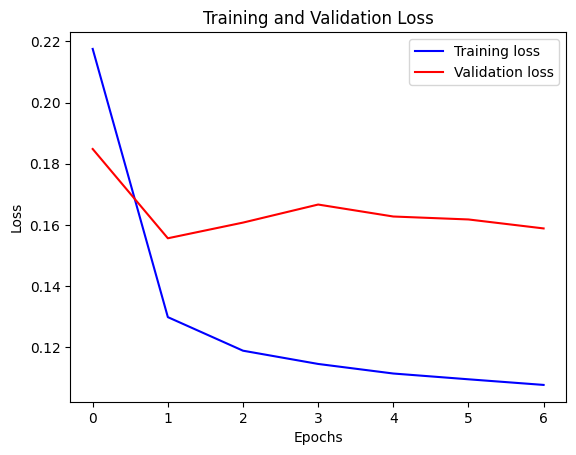

In [20]:
# Visualize loss
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")

## Analysis
- Looks like the training loss improved, but validation loss didn't.
- This seems like the model overfitted on the training dataset.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Error: 5.6 %


<ipython-input-22-37b277853782>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trueval=float(plot_data[1])
<ipython-input-22-37b277853782>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred=float(plot_data[2])


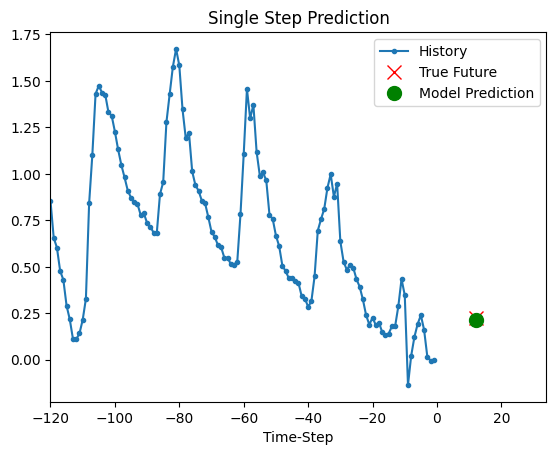

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Error: 144.4 %


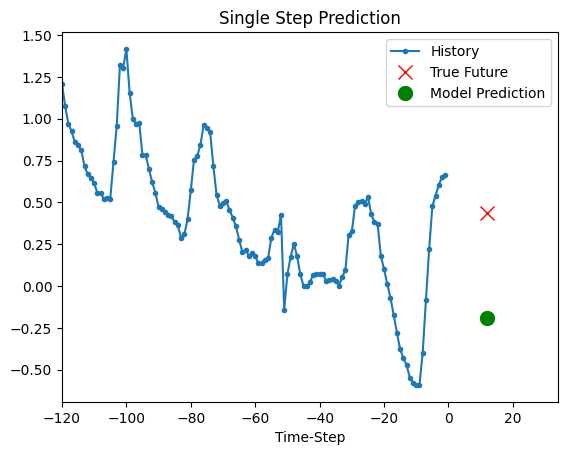

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Error: 19.76 %


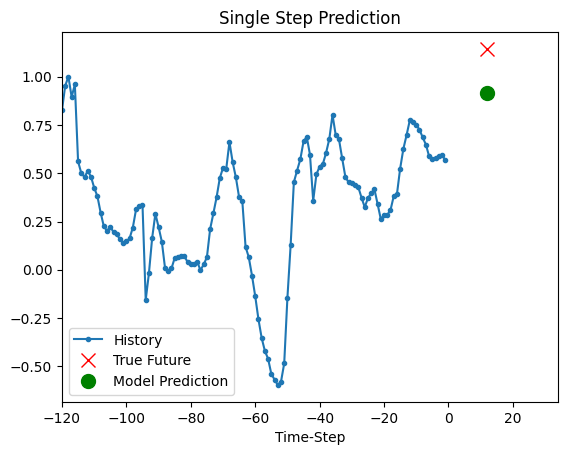

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Error: 25.24 %


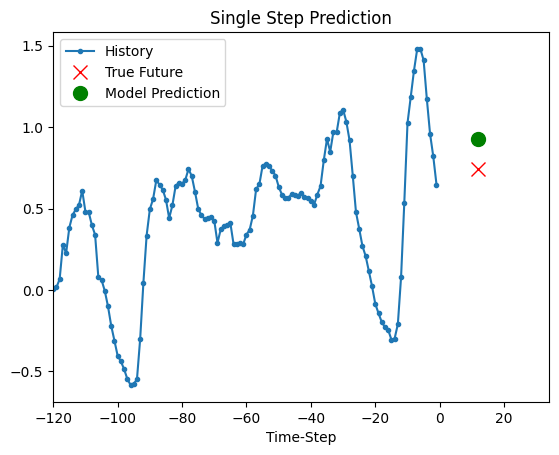

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Error: 41.83 %


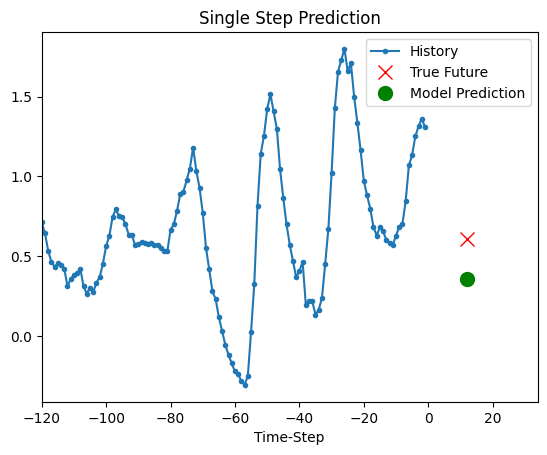

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Error: 14.2 %


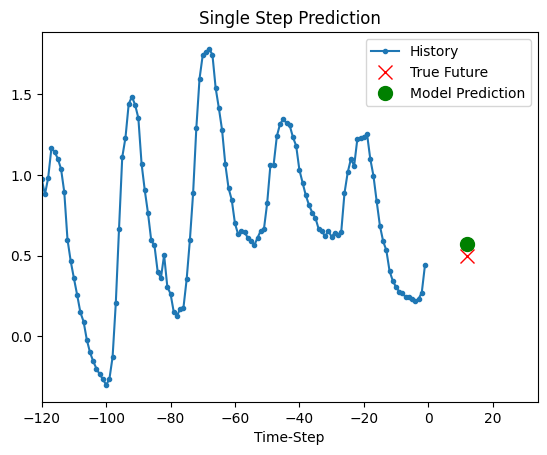

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Error: 25.09 %


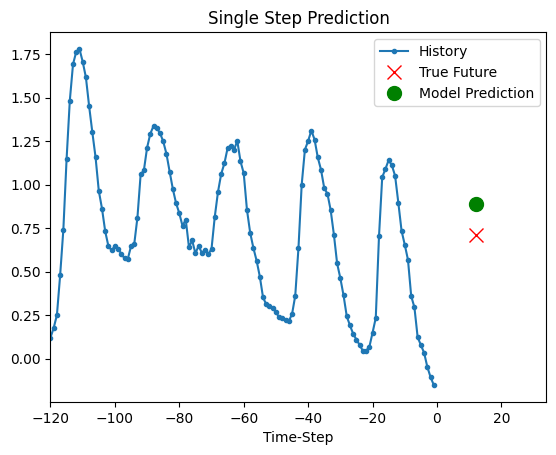

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Error: 26.73 %


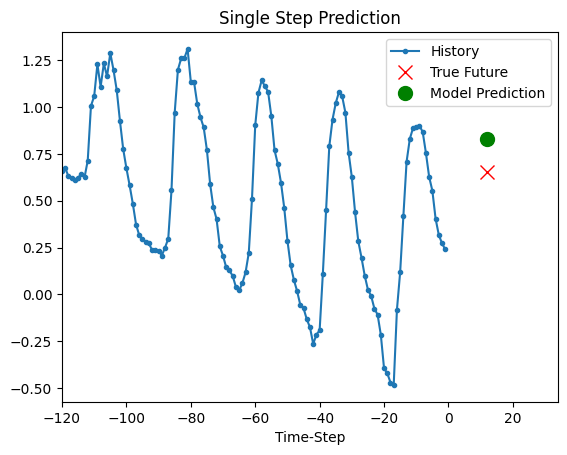

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Error: 11.64 %


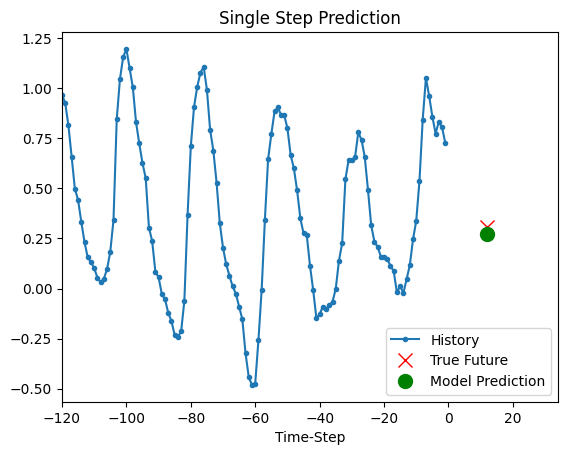

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Error: 23.54 %


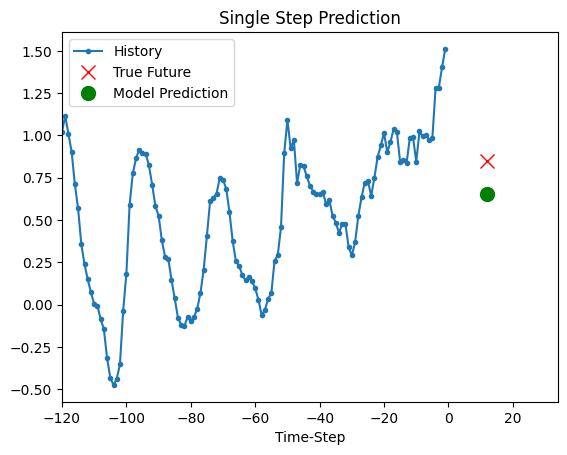

In [22]:
# Visualize the predictions (Single Step)
def show_plot(plot_data, delta, title):
    trueval=float(plot_data[1])
    pred=float(plot_data[2])
    err=round(((abs(pred-trueval)/trueval)*100),2)
    print("Error: "+str(err)+" %")
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)

    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])

    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

# This runs the show_plot() function
for x, y in dataset_val.take(10):
    show_plot([x[0][:, 1].numpy(),
               y[0].numpy(),
               model.predict(x)[0]],
              12,
              "Single Step Prediction",)